# Meta Learning Tutorial with the Sinusoid Regression Dataset

In [10]:
import functools

import matplotlib.pyplot as plt
import numpy as np

import jax
import jax.numpy as jnp
import optax

import haiku as hk

from tensorflow_probability.substrates import jax as tfp

import sinusoid_regression_dataset
import maml
import nets

tfd = tfp.distributions

## Explore the dataset a bit

Plotting and exploration based on https://github.com/ericjang/maml-jax/blob/master/maml.ipynb

In [2]:
num_shots = 50
sinusoid = sinusoid_regression_dataset.SinusoidRegression(4, num_shots)

support, query = next(sinusoid.train_set)

In [3]:
def plot_example(support, query):
    plt.figure(figsize=(16, 10))
    plt.scatter(support[0], support[1], label='Support set')
    plt.scatter(query[0], query[1], label='Query set')
    plt.legend()

Plot a batch of the support and query sets.

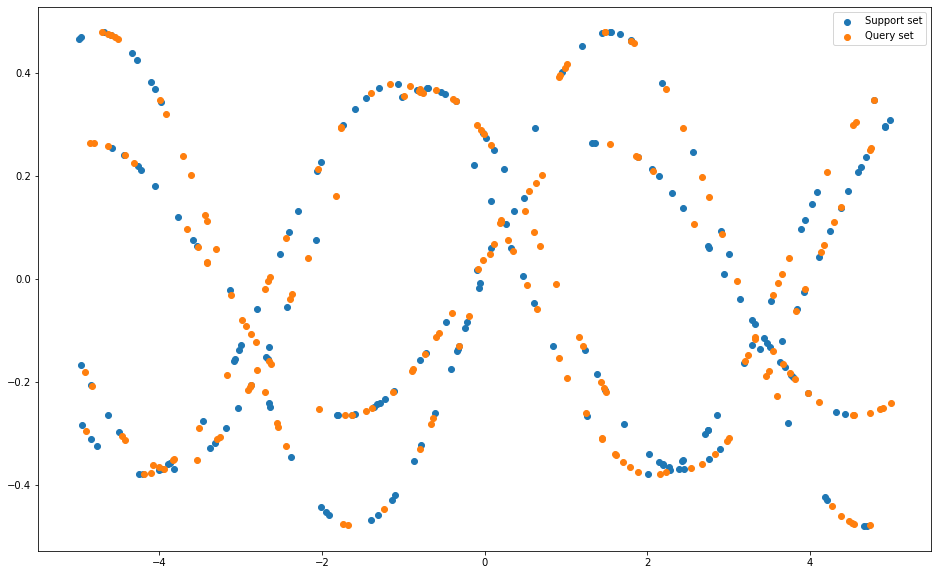

In [4]:
plot_example(support, query)

## Defining a training loop

In [5]:
@functools.partial(jax.jit, static_argnums=[0, 1])
def update(model, opt, prior_params, opt_state, support, query):
    grads = model.update_step(prior_params, support, query)
    updates, new_opt_state = opt.update(grads, opt_state)
    new_params = optax.apply_updates(prior_params, updates)
    return new_params, new_opt_state
    

def train(model, data, lr=0.001, steps=1000):
    eval_losses = []
    opt = optax.flatten(optax.adam(lr))
    opt_state = opt.init(model.prior_params)
    for step in range(steps):
        model.prior_params, opt_state = update(model, opt, model.prior_params, opt_state, *next(data.train_set))
        if step % 100 == 0:
            eval_support, eval_query = next(data.eval_set)
            posterior_params = model.adaptation_step(model.prior_params, *eval_support)
            pred = model(posterior_params, eval_query[0])
            eval_loss = -pred.log_prob(eval_query[1]).mean()
            eval_mse = ((pred.mode() - eval_query[1]) ** 2).sum(axis=-1).mean()
            eval_losses.append(eval_loss)
            print('Training step: {} -- loss: {} -- mse: {}'.format(step, eval_loss, eval_mse))
    return eval_losses
            


## Train MAML

In [8]:
def net(x):
    x = hk.BatchApply(nets.mlp, 2)(x)
    dist = tfd.Independent(tfd.Normal(x, 1.), 1)
    return dist

model = maml.Maml(net, support[0], 0.1, adaptation_steps=5)


for lr in [1e-3, 1e-2, 1e-4]:
    train(model, sinusoid, lr, steps=800)

Training step: 0 -- loss: 0.9371097087860107 -- mse: 0.03634239733219147
Training step: 100 -- loss: 0.9507845640182495 -- mse: 0.06369207054376602
Training step: 200 -- loss: 0.9282522201538086 -- mse: 0.018627362325787544
Training step: 300 -- loss: 0.9356703162193298 -- mse: 0.03346334770321846
Training step: 400 -- loss: 0.9301034808158875 -- mse: 0.02233000658452511
Training step: 500 -- loss: 0.9279661178588867 -- mse: 0.018055491149425507
Training step: 600 -- loss: 0.9272682070732117 -- mse: 0.016659388318657875
Training step: 700 -- loss: 0.9242382645606995 -- mse: 0.01059978548437357
Training step: 0 -- loss: 0.9819881916046143 -- mse: 0.12609954178333282
Training step: 100 -- loss: 0.9293155670166016 -- mse: 0.020754370838403702
Training step: 200 -- loss: 0.948483407497406 -- mse: 0.059089601039886475
Training step: 300 -- loss: 0.9247834086418152 -- mse: 0.011689872480928898
Training step: 400 -- loss: 0.9306895732879639 -- mse: 0.023502172902226448
Training step: 500 -- l

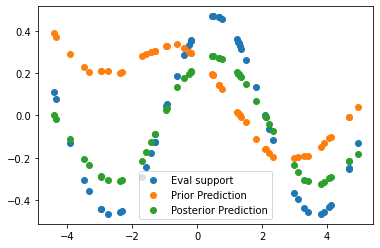

In [24]:
eval_support, eval_query = next(sinusoid.eval_set)
pred = model(model.prior_params, eval_query[0]).mode()
plt.scatter(eval_query[0][0], eval_query[1][0], label='Eval support')
plt.scatter(eval_query[0][0], pred[0], label='Prior Prediction')
                      
posterior_params = model.adaptation_step(model.prior_params, *eval_support)
pred = model(posterior_params, eval_query[0]).mode()

plt.scatter(eval_query[0][0], pred[0], label='Posterior Prediction')
plt.legend()